In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
import logging
import numpy as np
import seaborn as sns

In [2]:
# Load the data from Excel with error handling
try:
    df = pd.read_excel("/content/ARW_structured.xlsx", header=None)
except FileNotFoundError:
    print("File not found. Please check the file path.")
    exit(1)
except Exception as e:
    print("An error occurred while loading the data:", e)
    exit(1)

# Validate and extract the headers (dates) and all line items for forecasting
if df.shape[0] < 14 or df.shape[1] < 2:  # Expecting 15 rows and at least 2 columns
    print("Invalid data format. Expected at least 15 rows and 2 columns.")
    exit(1)

# Extract dates from the first row
dates = df.iloc[0, 1:].values.tolist()

# Extract line items and their values from the remaining rows
line_items = []
for i in range(1, 14):  # Loop through 15 rows (indexes 1 to 15)
    line_item = df.iloc[i, 0]
    values = df.iloc[i, 1:].values.tolist()
    line_items.append((line_item, values))

# Print the extracted line items once
print("Extracted Line Items:")
for item, _ in line_items:
    print(item)


Extracted Line Items:
Revenue
SG&A Expense
Operating Expenses
Operating Income
Interest Expense
Cap-Ex
D&A
Total Current Liabilities
Total Current Assets
Gross Profit 
Taxes
EBITA
EBIT


In [7]:
print(df.info)

<bound method DataFrame.info of                           0                    1           2           3    \
0                       Dates  2023-12-31 00:00:00  30-09-2023  01-07-2023   
1                     Revenue              7849.16     8007.02     8514.52   
2                SG&A Expense               590.04      563.15       617.2   
3          Operating Expenses              7492.81     7635.58     8111.93   
4            Operating Income               356.34      371.44      402.58   
5            Interest Expense               100.85       99.08      101.23   
6                      Cap-Ex                25.51       20.67       16.99   
7                         D&A                43.17       45.01       46.26   
8   Total Current Liabilities             13187.88    11936.03     10669.3   
9        Total Current Assets             18327.48    17305.96    17131.21   
10              Gross Profit                946.38      934.59     1019.79   
11                      Taxes   

In [9]:
# Assuming 'df' is the DataFrame containing your data (loaded from 'ARW_structured.xlsx')

# Transpose the DataFrame to have line items as columns
df_transposed = df.set_index(0).T  # Set first column as index and transpose

# Remove the first row (which contains original column headers/dates)
df_transposed = df_transposed[1:]  # Select rows from index 1 onwards

# Convert all columns to numeric, handling errors
for col in df_transposed.columns:
    df_transposed[col] = pd.to_numeric(df_transposed[col], errors='coerce')

# Calculate basic statistics for the whole dataset
basic_stats = df_transposed.describe()

print(basic_stats)


0      Dates      Revenue  SG&A Expense  Operating Expenses  Operating Income  \
count    0.0   138.000000    138.000000          138.000000        138.000000   
mean     NaN  3869.651377    337.084710         3705.722899        163.929130   
std      NaN  2576.042642    180.058426         2464.601519        120.073495   
min      NaN   222.290000     38.110000          216.580000        -73.830000   
25%      NaN  1845.590000    186.595000         1779.522500         83.992500   
50%      NaN  3404.625000    326.145000         3285.410000        145.125000   
75%      NaN  5692.860000    497.770000         5489.062500        228.872500   
max      NaN  9460.840000    653.640000         8925.520000        535.320000   

0      Interest Expense      Cap-Ex         D&A  Total Current Liabilities  \
count        138.000000  134.000000  138.000000                 136.000000   
mean          30.367681   21.074776   23.514275                3512.505809   
std           19.454182   14.167643 

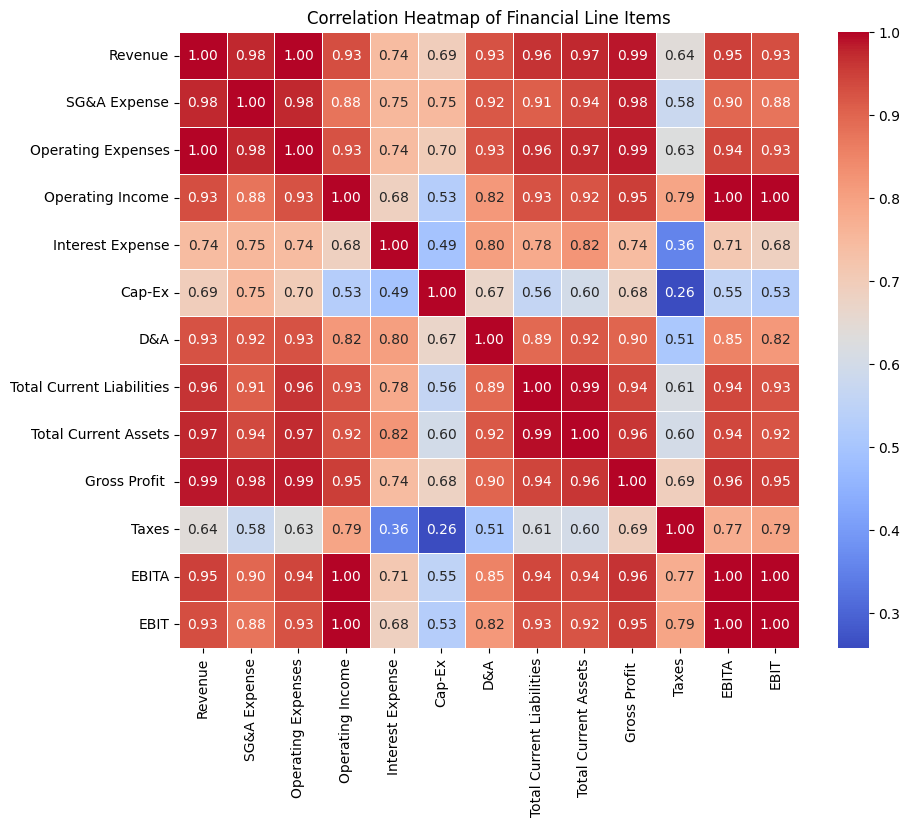

In [ ]:
# Convert the data into a format suitable for correlation calculation
data_for_correlation = pd.DataFrame({line_item: values for line_item, values in line_items}, index=dates)

# Calculate the correlation matrix
correlation_matrix = data_for_correlation.corr()

# Generate a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Financial Line Items")
plt.show()

In [18]:
# Create a DataFrame for each line item
data_frames = []
for line_item, values in line_items:
    data = pd.DataFrame({
        'ds': dates,
        'y': values,
        'line_item': line_item  # Add line_item column
    })
    data['ds'] = pd.to_datetime(data['ds'], dayfirst=True)

    # Handling missing values
    data['y'] = data['y'].interpolate(method='linear', limit_direction='both')  # Interpolation

    # Custom imputation based on linear regression
    if line_item == 'Interest Expense':
        # Assuming 'revenue_data' is the DataFrame for 'Revenue'
        revenue_data = next((df for df in data_frames if df['line_item'].iloc[0] == 'Revenue'), None)

        if revenue_data is not None and not revenue_data.empty:
            valid_data = data.dropna(subset=['y']).merge(revenue_data.dropna(subset=['y']), on='ds', suffixes=('_interest', '_revenue'))

            if not valid_data.empty:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    model = LinearRegression()
                    model.fit(valid_data[['y_revenue']], valid_data['y_interest'])

                    missing_indices = data['y'].isnull()
                    if any(missing_indices):
                        data.loc[missing_indices, 'y'] = model.predict(revenue_data.loc[missing_indices, 'y'].values.reshape(-1, 1))

    # Skip line items where all values are NaN
    if not all(pd.isnull(data['y'])):
        data_frames.append(data)


<bound method LinearRegression.fit of LinearRegression()>
<bound method LinearRegression.fit of LinearRegression()>
<bound method LinearRegression.fit of LinearRegression()>
<bound method LinearRegression.fit of LinearRegression()>
<bound method LinearRegression.fit of LinearRegression()>
<bound method LinearRegression.fit of LinearRegression()>
<bound method LinearRegression.fit of LinearRegression()>
<bound method LinearRegression.fit of LinearRegression()>
<bound method LinearRegression.fit of LinearRegression()>
<bound method LinearRegression.fit of LinearRegression()>
<bound method LinearRegression.fit of LinearRegression()>
<bound method LinearRegression.fit of LinearRegression()>
<bound method LinearRegression.fit of LinearRegression()>


In [ ]:
# Create Prophet models for each line item with adjusted parameters and custom holidays
models = []
for data in data_frames:
    model = Prophet(
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10.0,
        holidays_prior_scale=20.0
    )
    model.add_country_holidays(country_name='US')
    models.append(model)

# Fit each model to the respective data with error handling
for i, model in enumerate(models):
    try:
        model.fit(data_frames[i])
    except Exception as e:
        print(f"An error occurred while fitting the model for {line_items[i][0]}:", e)
        exit(1)

# Create a DataFrame for future dates (next 5 years starting from 2024)
future_dates = pd.date_range(start='2024-01-01', periods=5*4, freq='Q')  # Quarterly for 5 years
future_dates = pd.DataFrame({'ds': future_dates})


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmjgugl9e/924r5hvc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmjgugl9e/jq7vchf7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91714', 'data', 'file=/tmp/tmpmjgugl9e/924r5hvc.json', 'init=/tmp/tmpmjgugl9e/jq7vchf7.json', 'output', 'file=/tmp/tmpmjgugl9e/prophet_model1brpew83/prophet_model-20241202191318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:13:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:13:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

In [ ]:
# Forecast future values for each line item
forecast_results = []  # List to store forecasts for each line item

for i, model in enumerate(models):
    forecast = model.predict(future_dates)

    # Create a dictionary for each line item's forecasted data
    forecast_dict = {
        'line_item': line_items[i][0],
        'forecast': forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    }

    # Append the forecast dictionary to the list
    forecast_results.append(forecast_dict)

# Print the forecasted values for the next 5 years (quarterly) for each line item
print("\nForecasted Line Items for the Next 5 Years (Quarterly):\n")
for result in forecast_results:
    line_item = result['line_item']
    forecast_df = result['forecast']
    print(f"{line_item} Forecast:")
    print(forecast_df.tail(20))



Forecasted Line Items for the Next 5 Years (Quarterly):

Revenue Forecast:
           ds          yhat    yhat_lower    yhat_upper
0  2024-03-31   8962.415388   8425.729100   9506.880865
1  2024-06-30   9063.198997   8542.871133   9573.881787
2  2024-09-30   9081.077823   8569.118956   9621.580910
3  2024-12-31   9341.710402   8761.981356   9892.064667
4  2025-03-31   9247.978615   8734.837833   9760.235454
5  2025-06-30   9348.957955   8845.939786   9881.393757
6  2025-09-30   9392.771949   8857.199398   9919.038359
7  2025-12-31   9614.111383   9099.827725  10130.071448
8  2026-03-31   9524.688068   8991.303784  10043.987793
9  2026-06-30   9633.676856   9110.399862  10163.845819
10 2026-09-30   9700.347966   9172.401754  10223.635910
11 2026-12-31   9887.743567   9349.922054  10401.623044
12 2027-03-31   9792.606257   9230.812709  10316.174105
13 2027-06-30   9917.349273   9428.814864  10474.672744
14 2027-09-30  10003.801469   9459.669420  10516.757518
15 2027-12-31  10457.963376 

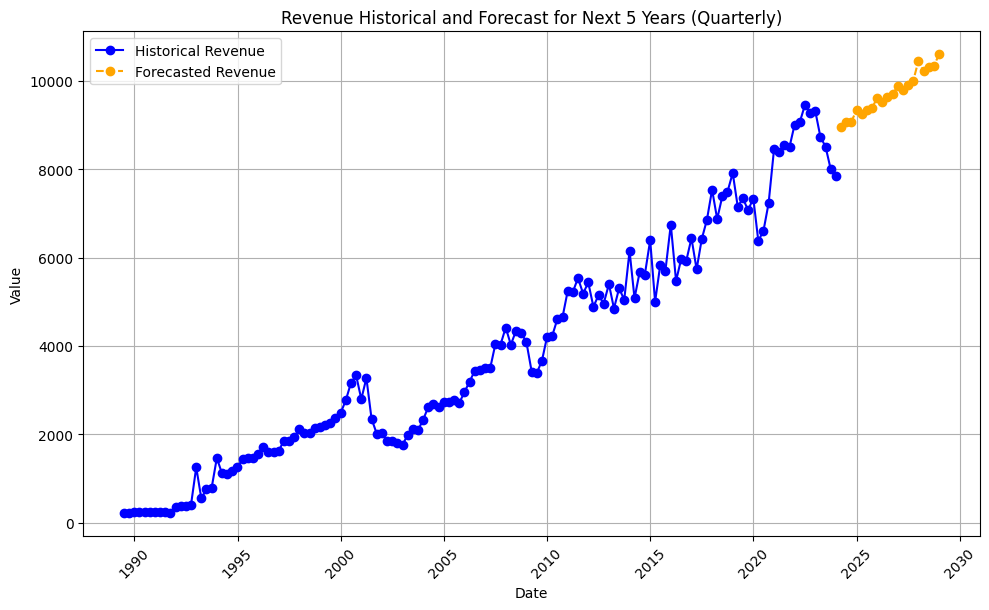

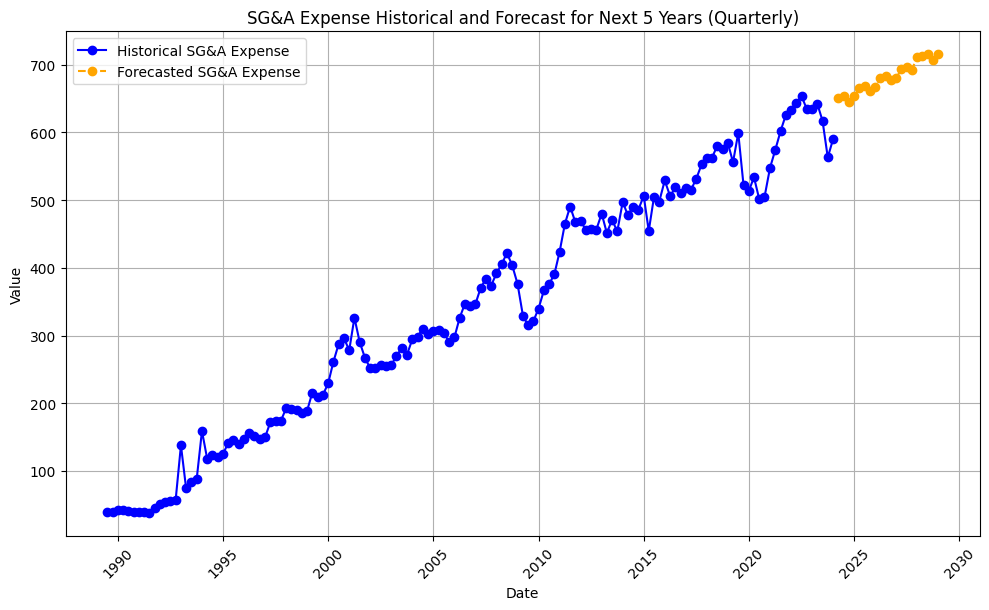

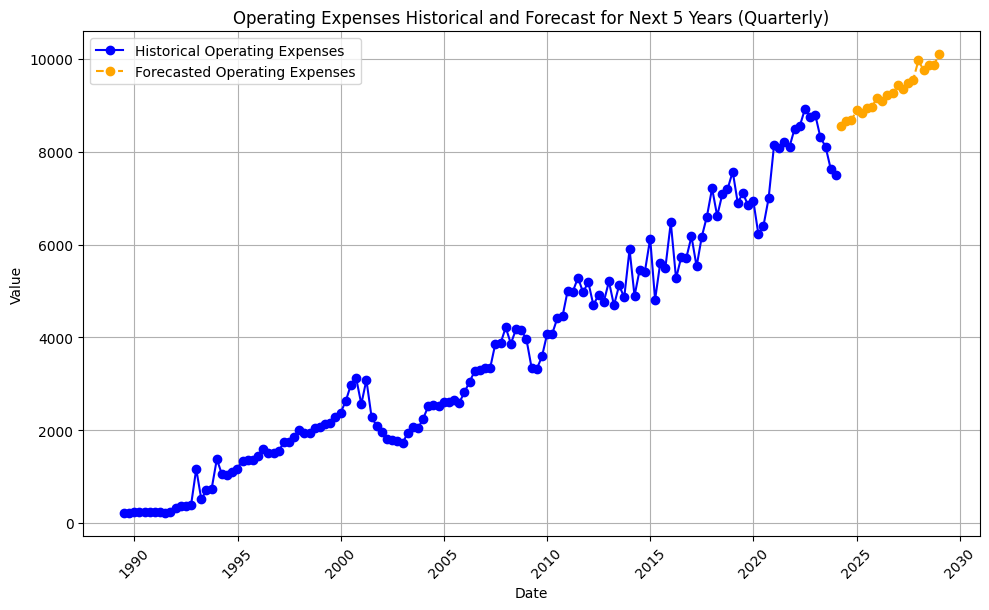

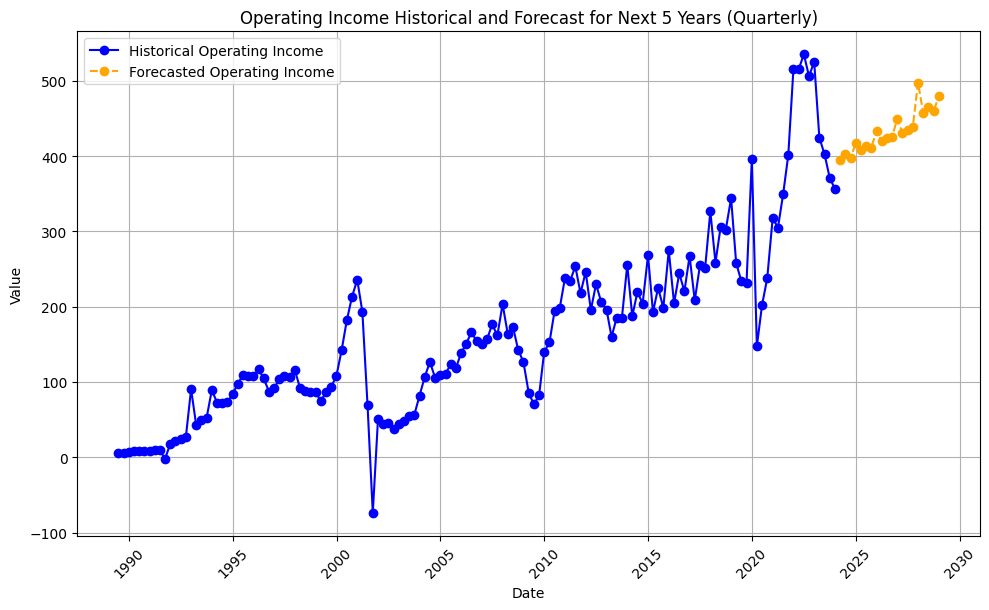

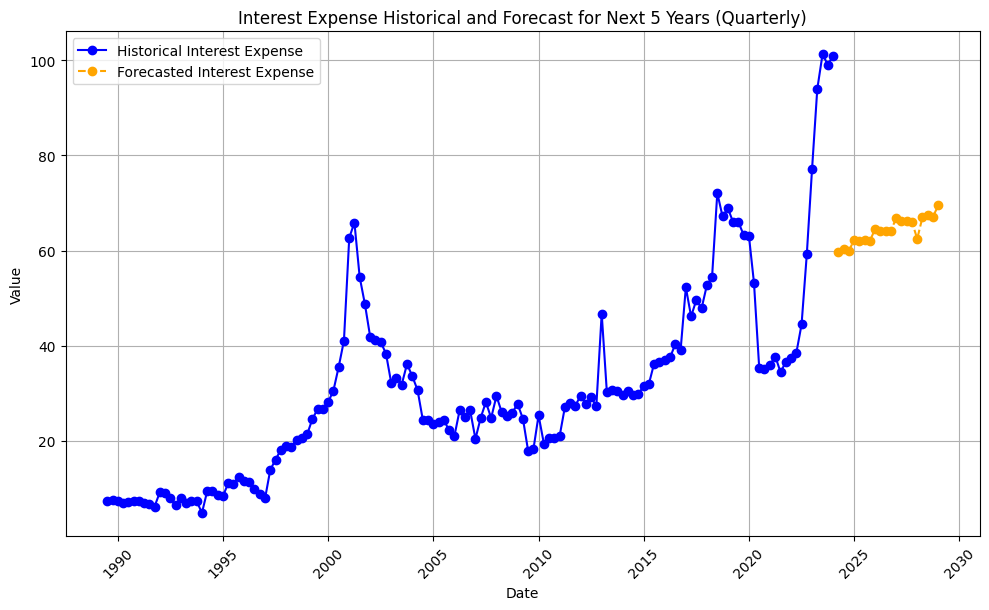

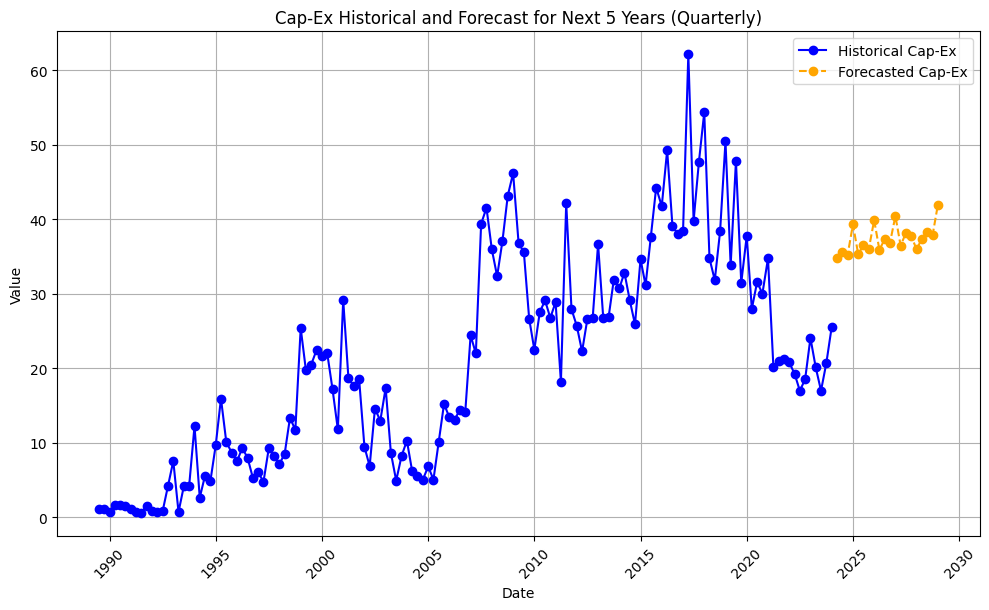

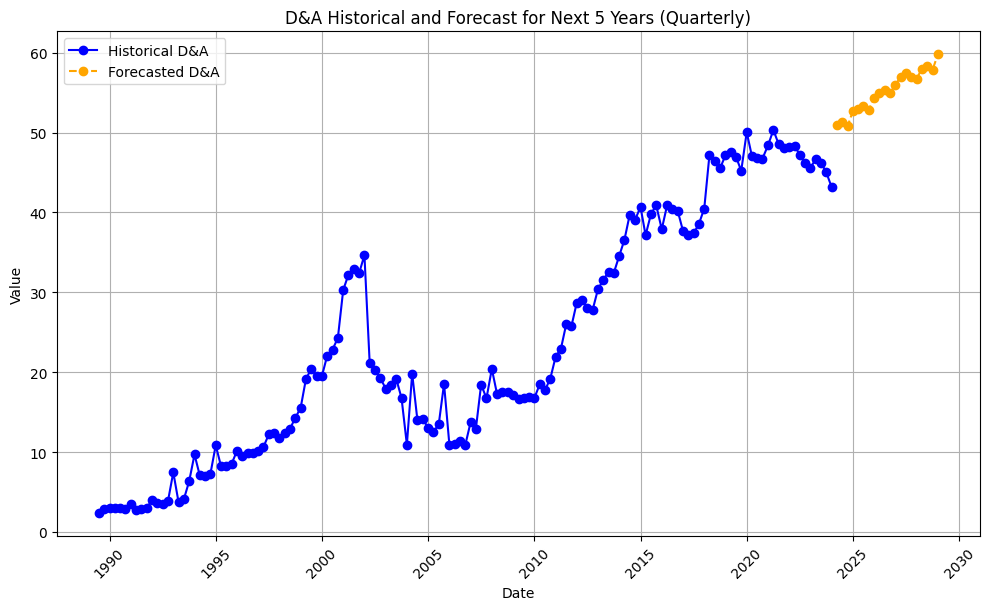

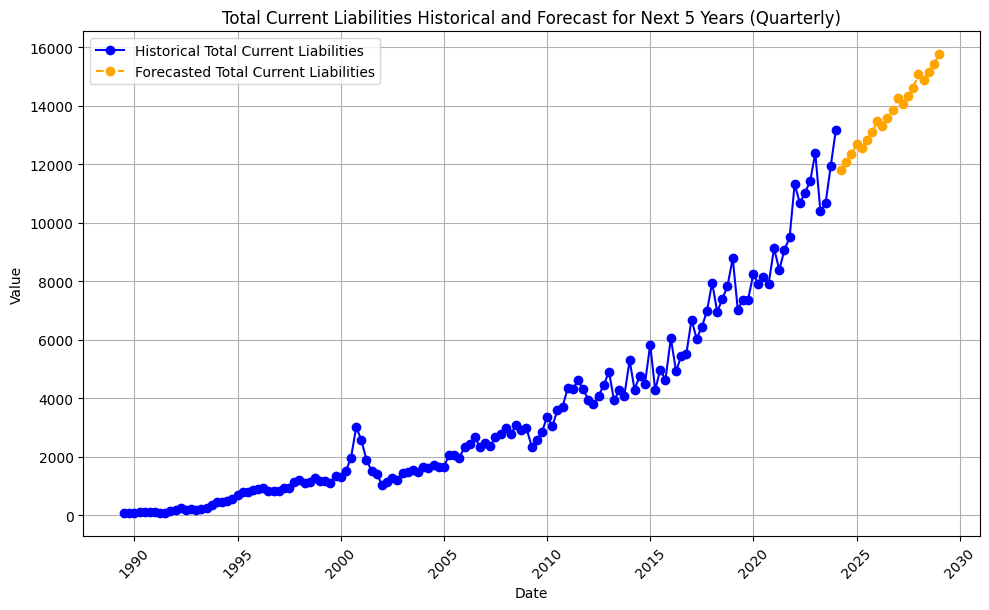

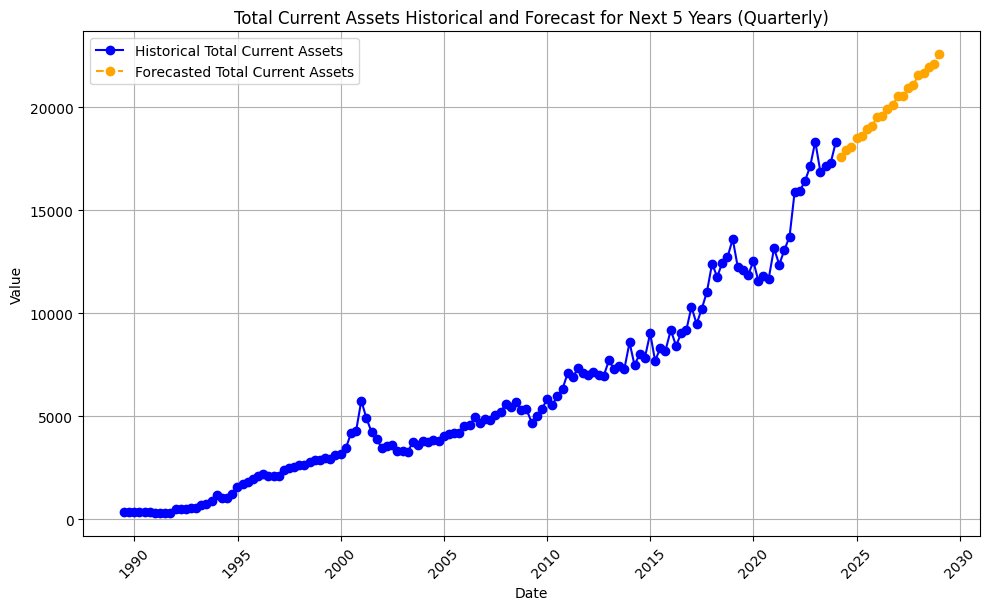

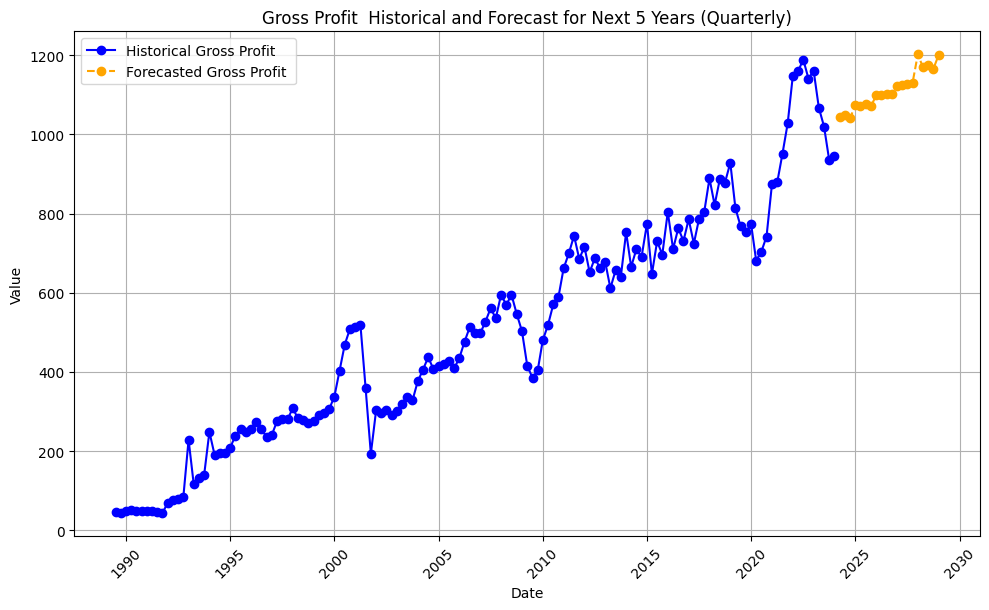

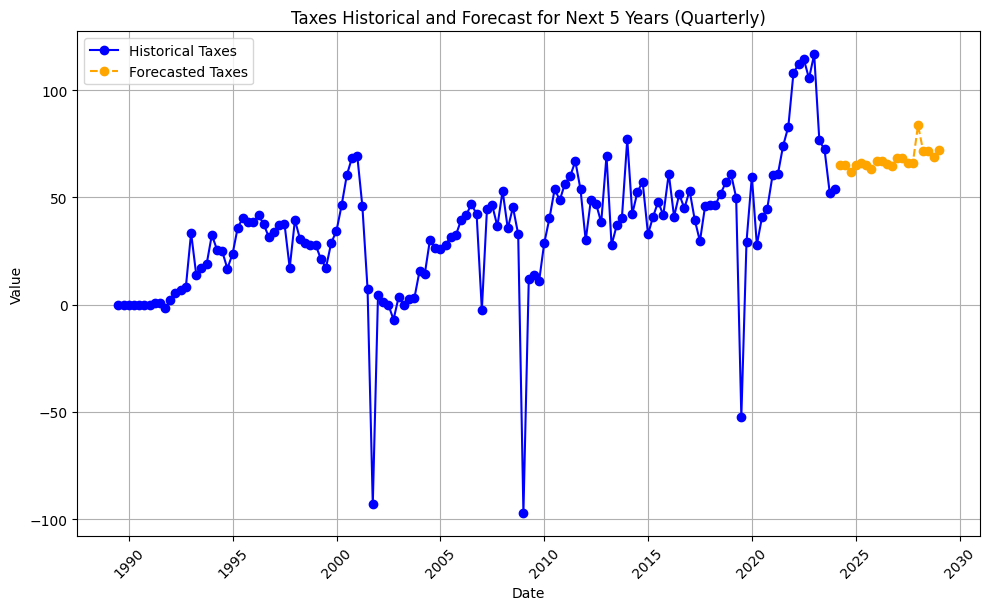

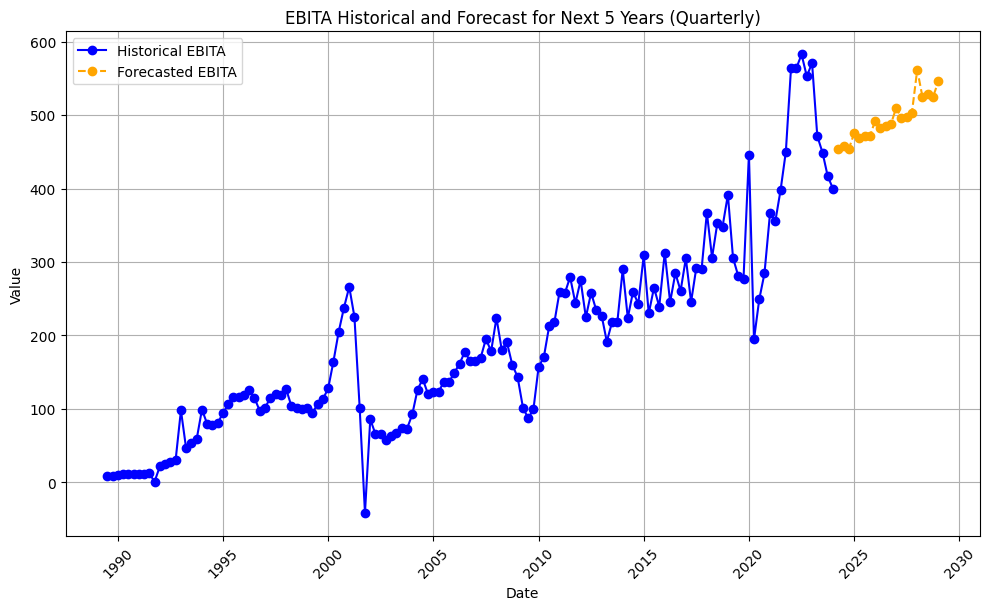

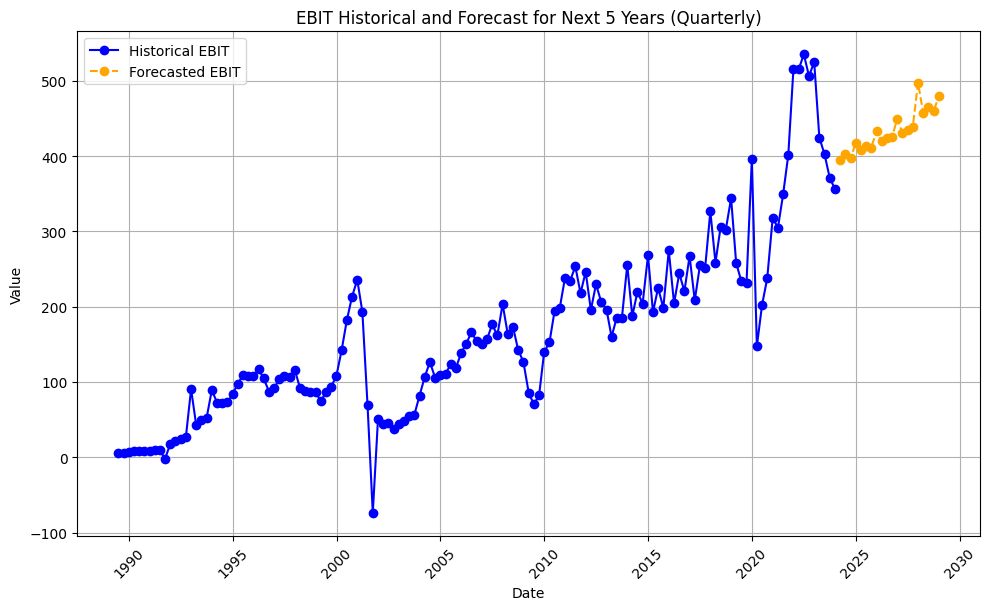

In [ ]:
# Plot historical and forecasted values for each line item
for result in forecast_results:
    line_item = result['line_item']
    forecast_df = result['forecast']
    data = next(data for data in data_frames if data['line_item'].iloc[0] == line_item)
    plt.figure(figsize=(10, 6))

    # Plot historical data with blue color, lines, and markers
    plt.plot(data['ds'], data['y'], label='Historical ' + line_item, color='blue', marker='o', linestyle='-')

    # Plot forecasted data with orange color, lines, and markers
    plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecasted ' + line_item, color='orange', marker='o', linestyle='--')

    plt.title(f'{line_item} Historical and Forecast for Next 5 Years (Quarterly)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()  # Adjust layout for better spacing
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


In [ ]:
# Calculate FCFF (Free Cash Flow to Firm)
total_current_liabilities = df.loc[df.iloc[:, 0] == "Total Current Liabilities", df.columns[1]].values[0]
total_current_assets = df.loc[df.iloc[:, 0] == "Total Current Assets", df.columns[1]].values[0]

# Initialize list for FCFF
fcff = []

# Calculate FCFF for each period (adjusting for year and quarter)
num_years = 5  # Forecasting for 5 years
quarters_per_year = 4  # Quarterly data

for i in range(len(forecast_results[0]['forecast']['yhat'])):
    # Calculate Earnings Before Interest and Taxes (EBIT)
    ebit = forecast_results[0]['forecast']['yhat'][i] - forecast_results[2]['forecast']['yhat'][i] - forecast_results[4]['forecast']['yhat'][i]

    # Calculate Tax Effects
    tax_effect = ebit * forecast_results[7]['forecast']['yhat'][i]

    # Calculate FCFF
    if(i == 0):
        net_change_working_cap = (forecast_results[10]['forecast']['yhat'][i] - forecast_results[11]['forecast']['yhat'][i]) - (total_current_assets - total_current_liabilities)
        fcff_value = (ebit * (1 - 0.21)) + forecast_results[8]['forecast']['yhat'][i] - net_change_working_cap - forecast_results[9]['forecast']['yhat'][i]
        fcff.append(fcff_value)
    else:
        net_change_working_cap = (forecast_results[10]['forecast']['yhat'][i] - forecast_results[11]['forecast']['yhat'][i]) - (forecast_results[10]['forecast']['yhat'][i-1] - forecast_results[11]['forecast']['yhat'][i-1])
        fcff_value = (ebit * (1 - 0.21)) + forecast_results[8]['forecast']['yhat'][i] - net_change_working_cap - forecast_results[9]['forecast']['yhat'][i]
        fcff.append(fcff_value)

# Output FCFF for each period in the format "Year X, Quarter Y"
for i, fcff_value in enumerate(fcff):
    year = (i // quarters_per_year) + 1  # Determine the year (starting from 1)
    quarter = (i % quarters_per_year) + 1  # Determine the quarter (1 to 4)
    print(f"Year {year}, Quarter {quarter}: FCFF = {fcff_value}")


Year 1, Quarter 1: FCFF = 22355.88429977448
Year 1, Quarter 2: FCFF = 17148.763811229855
Year 1, Quarter 3: FCFF = 17290.060421564383
Year 1, Quarter 4: FCFF = 17766.667326785584
Year 2, Quarter 1: FCFF = 17807.640650359135
Year 2, Quarter 2: FCFF = 18142.624297585437
Year 2, Quarter 3: FCFF = 18297.746628050154
Year 2, Quarter 4: FCFF = 18763.648347510345
Year 3, Quarter 1: FCFF = 18776.179507365847
Year 3, Quarter 2: FCFF = 19121.571295936985
Year 3, Quarter 3: FCFF = 19292.849029891608
Year 3, Quarter 4: FCFF = 19760.743889723664
Year 4, Quarter 1: FCFF = 19727.7041906493
Year 4, Quarter 2: FCFF = 20085.583095953574
Year 4, Quarter 3: FCFF = 20275.27256981789
Year 4, Quarter 4: FCFF = 20733.230207333276
Year 5, Quarter 1: FCFF = 20770.15186219638
Year 5, Quarter 2: FCFF = 21116.75542315643
Year 5, Quarter 3: FCFF = 21258.05203349083
Year 5, Quarter 4: FCFF = 21734.65893871194
